In [2]:
import os, random
import cv2
import numpy as np
import pyvista as pv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
from pytorch3d.renderer import look_at_rotation
from pytorch3d.transforms import matrix_to_quaternion
import glob

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
def sample_clip_camera_pose():
    """
    Sample camera position in positive x hemisphere.
    """
    az = random.uniform(-85, 85)
    el = random.uniform(-30, 30)
    dist = random.uniform(35, 60)
    x = dist * np.cos(np.radians(el)) * np.cos(np.radians(az))
    y = dist * np.cos(np.radians(el)) * np.sin(np.radians(az))
    z = dist * np.sin(np.radians(el))
    return np.array([x, y, z])


def composite_images(bg, fg, mask):
    """Alpha composite fg over bg using mask"""
    return fg * mask[..., None] + bg * (1 - mask[..., None])

In [4]:
clip_mesh_path = "/home/exouser/pose_estim/clipestimator/data/mesh/clipMesh.obj"
mesh = pv.read(clip_mesh_path)
# Uniform silver color
silver = np.full((mesh.n_points, 3), 0.8, dtype=np.float32)
mesh["Color"] = silver

In [5]:
def render_clip_pyvista(cam_pos):
    p = pv.Plotter(off_screen=True, window_size=(256,256))
    p.add_mesh(
        mesh,
        scalars="Color",
        rgb=True,
        smooth_shading=True,
        specular=1.0,
        specular_power=50.0,
        ambient=0.005,
        diffuse=0.9
    )
    p.camera_position = [
        (cam_pos[0], cam_pos[1], cam_pos[2]),
        (0, 0, 0),
        (0, 0, 1),
    ]
    head = pv.Light(position=cam_pos, color=[1,1,1], light_type='headlight')
    p.add_light(head)
    img = p.screenshot(return_img=True, transparent_background=True)
    p.close()
    img = img.astype(np.float32) / 255.0
    return img  # HxWx4

In [10]:
def load_backgrounds(folder, size=(256,256)):
    imgs=[]
    for f in os.listdir(folder):
        if f.lower().endswith(('.png','.jpg','.jpeg')):
            full=os.path.join(folder,f)
            im=cv2.imread(full)
            if im is None: continue
            rgb=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            rgb=cv2.resize(rgb, size)
            imgs.append(rgb.astype(np.float32)/255.0)
    return imgs


def load_foreign_objects(folder, size=(256,256)):
    objs=[]
    for f in os.listdir(folder):
        if not f.lower().endswith(('.png','.jpg','.jpeg')): continue
        path=os.path.join(folder,f)
        img=cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img is None: continue
        # ensure BGRA
        if img.ndim==2:
            img=cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
        elif img.shape[2]==3:
            alpha=np.ones(img.shape[:2],dtype=np.uint8)*255
            img=np.dstack([img,alpha])
        b,g,r,a=cv2.split(img)
        rgb=cv2.merge([r,g,b])
        a=a
        rgb_f=rgb.astype(np.float32)/255.0
        a_f=a.astype(np.float32)/255.0
        rgb_f=cv2.resize(rgb_f, size, interpolation=cv2.INTER_AREA)
        a_f=cv2.resize(a_f, size, interpolation=cv2.INTER_NEAREST)
        objs.append((rgb_f, a_f))
    return objs

backgrounds = load_backgrounds("/home/exouser/pose_estim/clipestimator/data/backgrounds")
foreign_objects = load_foreign_objects("/home/exouser/pose_estim/clipestimator/data/objects")

In [11]:
def generate_occlusion_mask_pca_adaptive(alpha, occlusion_level=0.3, width_sym=0.8):
    H,W=alpha.shape
    mask=np.ones_like(alpha)
    rows,cols=np.nonzero(alpha>0)
    if rows.size==0: return mask
    pts=np.stack([cols,rows],axis=1).astype(np.float32)
    ctr=pts.mean(0)
    cen=pts-ctr
    cov=cen.T@cen
    vals,vecs=np.linalg.eigh(cov)
    axis=vecs[:,np.argmax(vals)]
    proj=cen@axis
    mn,mx=proj.min(),proj.max()
    span=mx-mn
    if span<=0: return mask
    delta=span*0.1
    wmax=np.sum(proj>mx-delta)
    wmin=np.sum(proj<mn+delta)
    if min(wmax,wmin)/max(wmax,wmin)>width_sym:
        return mask
    occl=occlusion_level*span
    if wmax<wmin:
        thresh=mx-occl
        idx=proj>thresh
    else:
        thresh=mn+occl
        idx=proj<thresh
    mask[rows[idx], cols[idx]]=0
    return mask

In [12]:
def generate_synthetic_sample(
    blur_kernel=(5,5), blur_sigma=1.0
):
    # background
    bg=random.choice(backgrounds)
    # camera pose
    cam=sample_clip_camera_pose()
    # compute R,T via PyTorch3D
    cam_t=torch.from_numpy(cam.astype(np.float32)).unsqueeze(0).to(device)
    R_t=look_at_rotation(cam_t, device=device)[0].cpu().numpy()
    T=-(R_t@cam)
    # render
    rgba=render_clip_pyvista(cam)
    clip_rgb,clip_alpha=rgba[...,:3],rgba[...,3]
    # occlusion
    mask=generate_occlusion_mask_pca_adaptive(clip_alpha)
    alpha_occ=clip_alpha*mask
    # blur clip
    clip_pre=clip_rgb*alpha_occ[...,None]
    clip_blur=cv2.GaussianBlur(clip_pre, blur_kernel, blur_sigma, borderType=cv2.BORDER_CONSTANT)
    alpha_blur=cv2.GaussianBlur(alpha_occ, blur_kernel, blur_sigma, borderType=cv2.BORDER_CONSTANT)
    alpha_blur=np.clip(alpha_blur,0,1)
    comp=clip_blur + bg*(1-alpha_blur[...,None])
    # foreign objects
    n=random.randint(1,3)
    for _ in range(n):
        o_rgb,o_alpha=random.choice(foreign_objects)
        o_pre=o_rgb*o_alpha[...,None]
        o_blur=cv2.GaussianBlur(o_pre, blur_kernel, blur_sigma, borderType=cv2.BORDER_CONSTANT)
        a_blur=cv2.GaussianBlur(o_alpha, blur_kernel, blur_sigma, borderType=cv2.BORDER_CONSTANT)
        a_blur=np.clip(a_blur,0,1)
        comp=o_blur + comp*(1-a_blur[...,None])
    # noise
    noise=np.random.normal(0,0.02,comp.shape)
    comp_noisy=np.clip(comp+noise,0,1)
    return comp_noisy, R_t, T

In [13]:
output_folder = "/home/exouser/pose_estim/clipestimator/data/senthetic_data/"
os.makedirs(output_folder, exist_ok=True)
num_pre = 10  # number of samples to pre-generate
for i in range(num_pre):
    img, R_gt, T_gt = generate_synthetic_sample(blur_kernel=(7,7), blur_sigma=1.5)
    torch.save({
        'img': torch.from_numpy(img).permute(2,0,1),
        'R': torch.from_numpy(R_gt),
        'T': torch.from_numpy(T_gt)
    }, os.path.join(output_folder, f"sample_{i:05d}.pt"))
print(f"Pre-generated {num_pre} samples into {output_folder}")

NameError: name 'sample_clip_camera_pose' is not defined

In [14]:
import glob
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch
from pytorch3d.transforms import matrix_to_quaternion

# 1) Gather sample file paths
all_files = sorted(glob.glob(os.path.join(output_folder, 'sample_*.pt')))

# 2) Pre-load data into RAM with explicit float32 casting
imgs_list, quats_list, trans_list = [], [], []
for f in all_files:
    d = torch.load(f, map_location='cpu')
    # Ensure image tensor is float32
    img_t = d['img'].to(torch.float32)
    imgs_list.append(img_t)
    # Quaternion from rotation matrix
    R_mat = d['R'].to(torch.float32).unsqueeze(0)
    q = matrix_to_quaternion(R_mat)[0].to(torch.float32)
    quats_list.append(q)
    # Translation vector as float32
    t = d['T'].to(torch.float32)
    trans_list.append(t)

# 3) Stack into contiguous float32 tensors
imgs_tensor  = torch.stack(imgs_list).contiguous()    # (N, C, H, W)
quats_tensor = torch.stack(quats_list).contiguous()   # (N, 4)
trans_tensor = torch.stack(trans_list).contiguous()   # (N, 3)

# 4) Create TensorDataset and split into train/val
full_dataset = TensorDataset(imgs_tensor, quats_tensor, trans_tensor)
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 5) DataLoaders with pin_memory and no CPU workers
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size,
                          shuffle=False, pin_memory=True)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 8, Validation samples: 2


In [15]:
class PoseRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        from torchvision.models import resnet18, ResNet18_Weights
        backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature = nn.Sequential(*list(backbone.children())[:-1])
        self.fc = nn.Linear(512, 7)
    def forward(self, x):
        x = self.feature(x).view(x.size(0), -1)
        out = self.fc(x)
        q, t = out[:, :4], out[:, 4:]
        q = q / q.norm(dim=1, keepdim=True)
        return q, t

model = PoseRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def pose_loss(q_pred, t_pred, q_gt, t_gt, λ_rot=1.0, λ_trans=1.0):
    """
    Compute combined pose loss.
    Rotation loss: 1 - |dot(q_pred, q_gt)|
    Translation loss: MSE on translation vectors
    Returns total loss, rot loss, trans loss.
    """
    # Rotation loss
    cos = torch.abs((q_pred * q_gt).sum(dim=1))       # (B,)
    Lr  = torch.mean(1 - cos)
    # Translation loss
    Lt  = torch.mean((t_pred - t_gt).pow(2).sum(dim=1))
    return λ_rot * Lr + λ_trans * Lt, Lr, Lt

In [16]:
from tqdm import tqdm
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, qg, tg in tqdm(train_loader):
        imgs, qg, tg = imgs.to(device), qg.to(device), tg.to(device)
        qp, tp = model(imgs)
        loss, _, _ = pose_loss(qp, tp, qg, tg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataset):.4f}")

  0%|          | 0/8 [00:00<?, ?it/s]/home/exouser/anaconda3/envs/blvenv/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971093/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
  0%|          | 0/8 [00:54<?, ?it/s]


KeyboardInterrupt: 

Rot: 115.35±51.26°
Trans: 45.74±10.33


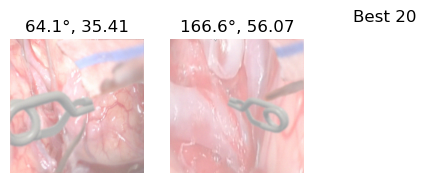

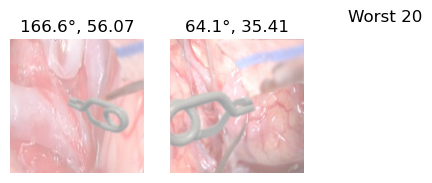

In [32]:
# Compute errors
rot_errs, trans_errs, imgs = [], [], []
model.eval()
with torch.no_grad():
    for imgs_b, qg, tg in val_loader:
        imgs_b = imgs_b.to(device)
        qp, tp = model(imgs_b)
        cos = torch.abs((qp*qg.to(device)).sum(dim=1))
        th = 2*torch.acos(torch.clamp(cos,-1,1))*(180/np.pi)
        te = torch.norm(tp - tg.to(device), dim=1)
        rot_errs += th.cpu().numpy().tolist()
        trans_errs += te.cpu().numpy().tolist()
        imd = imgs_b.cpu()*0.5+0.5
        imgs += imd.permute(0,2,3,1).numpy().tolist()

rot_arr=np.array(rot_errs); tr_arr=np.array(trans_errs)
print(f"Rot: {rot_arr.mean():.2f}±{rot_arr.std():.2f}°")
print(f"Trans: {tr_arr.mean():.2f}±{tr_arr.std():.2f}")

# Show best and worst
z_rot=(rot_arr-rot_arr.mean())/rot_arr.std()
z_tr=(tr_arr-tr_arr.mean())/tr_arr.std()
z=z_rot+z_tr
best=np.argsort(z)[:20]
worst=np.argsort(-z)[:20]

def show(idxs,title):
    cols=5; rows=(len(idxs)+cols-1)//cols
    plt.figure(figsize=(cols*2,rows*2))
    for i,idx in enumerate(idxs):
        plt.subplot(rows,cols,i+1)
        plt.imshow(imgs[idx]); plt.title(f"{rot_errs[idx]:.1f}°, {trans_errs[idx]:.2f}"); plt.axis('off')
    plt.suptitle(title)
    plt.show()

show(best,"Best 20")
show(worst,"Worst 20")